In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('My-Data.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
y = pd.DataFrame(y)

gen	nevals	max     	avg     
0  	30    	0.872846	0.571375 61.76248540007509
Time:  61.76248540007509
1  	19    	0.919962	0.644695
Time:  39.32369019999169
2  	20    	0.919962	0.640839
Time:  42.95190909993835
3  	20    	0.919962	0.664841
Time:  35.370866999961436
4  	20    	0.928963	0.642994
Time:  49.0680867000483
5  	20    	0.928963	0.604515
Time:  36.70284519996494
6  	20    	0.928963	0.590468
Time:  35.83697449997999
7  	20    	0.928963	0.611348
Time:  40.293961200048216
8  	19    	0.928963	0.472484
Time:  21.288947599940002
9  	20    	0.928963	0.649541
Time:  36.549592899973504
10 	20    	0.928963	0.541767
Time:  34.709759999997914
11 	20    	0.928963	0.744298
Time:  47.45310240006074
12 	20    	0.928963	0.511801
Time:  36.87111459998414
13 	19    	0.928963	0.660545
Time:  38.80869029997848
14 	20    	0.928963	0.607999
Time:  41.895683699985966
15 	20    	0.928963	0.601128
Time:  41.0479261999717
16 	20    	0.928963	0.430606
Time:  32.729411100037396
17 	20    	0.928963	0.653479
T

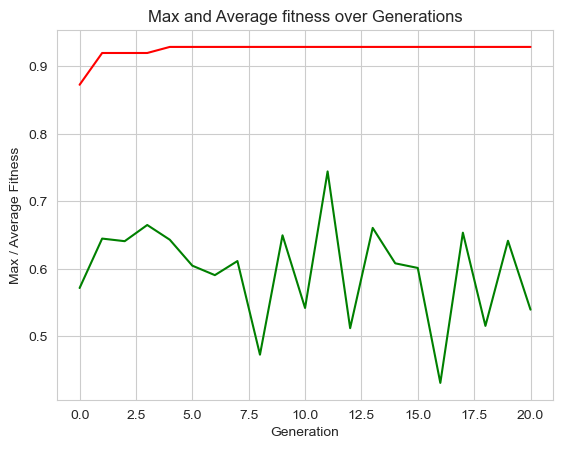

In [6]:
from immune_eval import Evaluation, get_data
from deap import base, tools, algorithms, creator
from elitism import eaSimpleWithElitism
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

# Genetic Algorithm constants:
POPULATION_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.9   # probability for mutating an individual
MAX_GENERATIONS = 20
FEATURE_PENALTY_FACTOR = 0.001
HALL_OF_FAME_SIZE = 10

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# X, y = get_data(GSO_FLOW)
eval_class = Evaluation(X, y, LGBMRegressor())

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("zeroOrOne", random.randint, a=0, b=1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(eval_class))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

def getR2(individual):
    numFeatureUsed = sum(individual)
    if numFeatureUsed == 0:
        return 0.0,
    else:
        r2_score = eval_class.getMeanR2(individual)
        return (r2_score - FEATURE_PENALTY_FACTOR * numFeatureUsed),

toolbox.register("evaluate", getR2)

toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=10.0/len(eval_class))

population = toolbox.populationCreator(n=POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    
population, logbook = eaSimpleWithElitism(population, toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)

print("- Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i], ", fitness = ", hof.items[i].fitness.values[0],
          ", R2 = ", eval_class.getMeanR2(hof.items[i]), ", features = ", sum(hof.items[i]))

maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.savefig("plots/GSO_LGBM_genetic_plot", dpi=1000)
plt.show()

# with open('objects/GSO_LGBM_genetic.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([maxFitnessValues, meanFitnessValues, hof.items[0]], f)